<a href="https://colab.research.google.com/github/jpaulorc/brazil_weather/blob/main/brazil_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brazil data Meteorological Exploration - 2000/2020**

### Data collected by INMET: National Institute of Meteorology.

<br>

### **Data obtained from:**

[Complete Brazil Weather Database - 2000/2020](https://www.kaggle.com/gbofrc/complete-brazil-weather-database-20002020)

Data collected by meteorological stations of the National Institute of Meteorology - INMET, distributed in the Brazilian territory between 2000 and 2021.

[INMET Automatic Stations](https://portal.inmet.gov.br/paginas/catalogoaut)

Location from INMET weather stations.

## Imports and libraries

In [1]:
!pip install bar-chart-race
!pip install matplotlib
!pip install missingno
!pip install folium
!pip install --upgrade plotly
!pip install altair

     |████████████████████████████████| 156 kB 5.1 MB/s 
     |████████████████████████████████| 25.3 MB 1.7 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [2]:
import csv
import glob
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import missingno as msno
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import bar_chart_race as bcr
import altair as alt
import requests
import folium
from branca.element import Figure

## Data reading.

Union between meteorological data and station location information.

##### Weather stations.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
station_file = '/content/drive/MyDrive/PUC/DATA_SCIENCE/DATAVIZ/TRABALHO/stations.csv'
stations_df = pd.read_csv(station_file, sep=';', usecols=['SG_ESTADO', 'DC_NOME', 'CD_ESTACAO', 'VL_LATITUDE', 'VL_LONGITUDE', 'VL_ALTITUDE'])

In [6]:
col_name = {
  'SG_ESTADO': 'uf',
  'DC_NOME': 'cityname',
  'CD_ESTACAO': 'station',
  'VL_LATITUDE': 'latitude',
  'VL_LONGITUDE': 'longitude',
  'VL_ALTITUDE': 'altitude'
}

stations_df.rename(columns=col_name, inplace=True)

In [7]:
region = {'region': ['N','N','N','N','N','N','N',
                     'NE','NE','NE','NE','NE','NE','NE','NE','NE',
                     'CO','CO','CO','CO','SE','SE','SE','SE','S','S','S'], 
          'uf': ['AM','RR','AP','PA','TO','RO','AC',
                 'MA','PI','CE','RN','PE','PB','SE','AL','BA',
                 'MT','MS','GO','DF','SP','RJ','ES','MG','PR','RS','SC']}

region_df = pd.DataFrame(region)

In [8]:
stations_df = pd.merge(left=stations_df, right=region_df, left_on='uf', right_on='uf')

##### Data unification originally divided into files by city.

In [9]:
brazil_weather_path = '/content/drive/MyDrive/PUC/DATA_SCIENCE/DATAVIZ/TRABALHO/brazil weather/'

In [10]:
os.chdir(brazil_weather_path)
file_extension = '.csv'
all_filenames = enumerate([i for i in glob.glob(f"*{file_extension}")])

all_cities_df = []

for index, row in all_filenames:
  filename = brazil_weather_path+row
  current_df = pd.read_csv(filename, sep=';', header=9)
  
  with open(filename, 'r') as file:
    csv_file = csv.reader(file, delimiter=';')
    header_list = [i for i in itertools.islice(csv_file, 9)]
    current_df['station'] = '.'.join(map(str, header_list[1])).split(': ')[1]
    all_cities_df.append(current_df)
  file.close()

weather_df = pd.concat(all_cities_df)

In [11]:
columns = {'Data Medicao': 'date', 
           'PRECIPITACAO TOTAL, DIARIO (AUT)(mm)': 'tot_precipitation',
           'PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB)': 'avg_atm_pressure',
           'TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C)': 'avg_dew_temp',
           'TEMPERATURA MAXIMA, DIARIA (AUT)(°C)': 'max_temp',
           'TEMPERATURA MEDIA, DIARIA (AUT)(°C)': 'avg_temp',
           'TEMPERATURA MINIMA, DIARIA (AUT)(°C)': 'min_temp',
           'UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)': 'avg_rel_humidity',
           'UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)': 'min_rel_humidity',
           'VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)': 'max_blast_wind',
           'VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)': 'avg_vel_wind'}

weather_df.rename(columns=columns, inplace=True)
weather_df.drop('Unnamed: 11', axis=1, inplace=True)

In [12]:
weather_df = pd.merge(left=weather_df, right=stations_df, left_on='station', right_on='station')

In [13]:
col_numbers = [
  'tot_precipitation',	'avg_atm_pressure',	'avg_dew_temp',	'max_temp',	'avg_temp',	'min_temp',	
  'avg_rel_humidity', 'min_rel_humidity',	'max_blast_wind', 'avg_vel_wind', 'latitude',	'longitude',	'altitude'
]

def asfloat_inplace(df: pd.DataFrame, columns: list):
  for col in columns:
    if df[col].dtype in [object, str]:
      df[col] = df[col].str.replace(',', '.').astype(float)

asfloat_inplace(weather_df, col_numbers)

In [14]:
all_cities_file = '/content/drive/MyDrive/PUC/DATA_SCIENCE/DATAVIZ/TRABALHO/weather.csv'

In [ ]:
#weather_df.to_csv(all_cities_file, index=False)

##### Unified Brazil meteorological data.

[Unified Dataset](https://drive.google.com/file/d/1iUIfjAa5InuExemh2jT9WNRnQestVlj2/view?usp=sharing)

In [19]:
weather_df = pd.read_csv(all_cities_file)

## 1. Identifying missing data.

Using the `missingno` library to identify and visualize missing data.

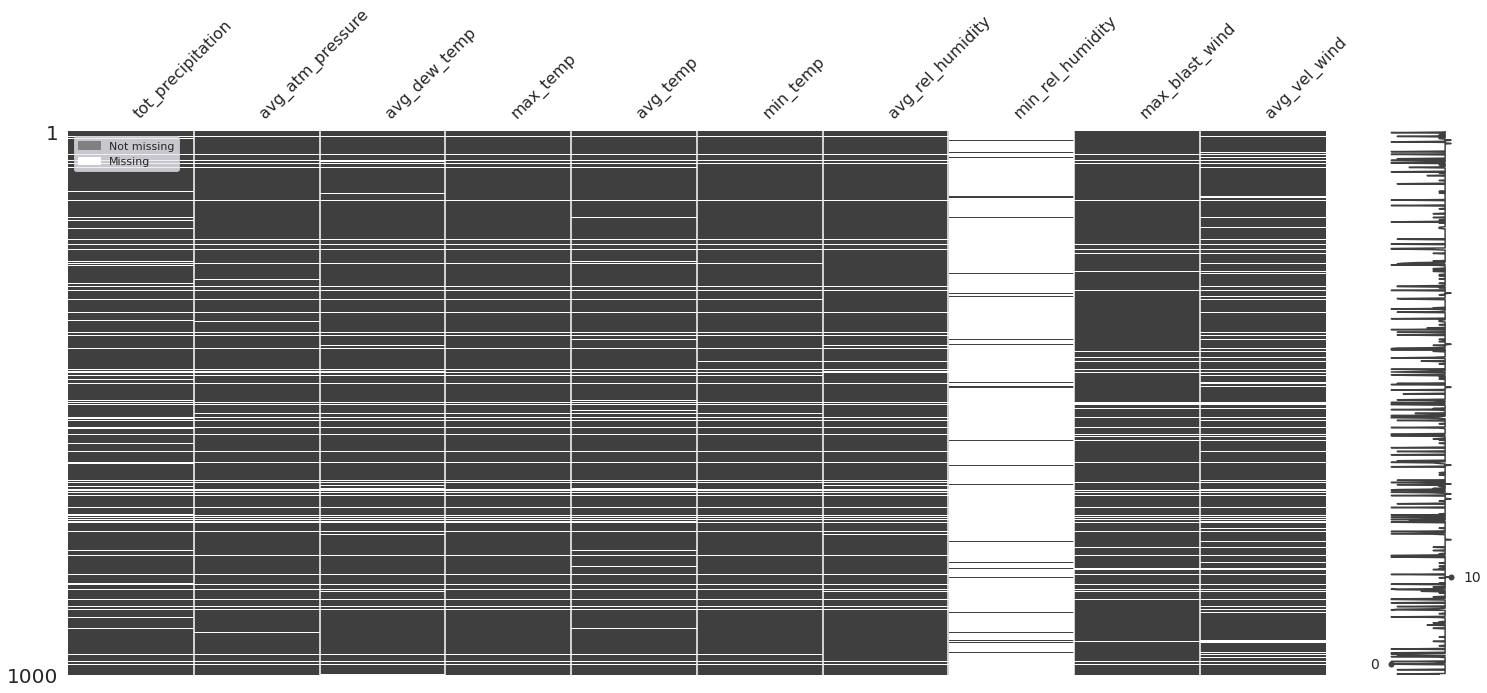

In [20]:
df = weather_df.loc[:, ['tot_precipitation', 'avg_atm_pressure', 'avg_dew_temp',
                                   'max_temp', 'avg_temp', 'min_temp', 'avg_rel_humidity',
                                   'min_rel_humidity', 'max_blast_wind', 'avg_vel_wind']]

msno.matrix(df.sample(1000))
gray_patch = mpatches.Patch(color='gray', label='Not missing')
white_patch = mpatches.Patch(color='white', label='Missing')
plt.legend(handles=[gray_patch, white_patch], loc='upper left')
plt.show()

## 2. Identification of the analyzed places.

According to the Latitude and Longitude information we can identify the location of the measuring stations.

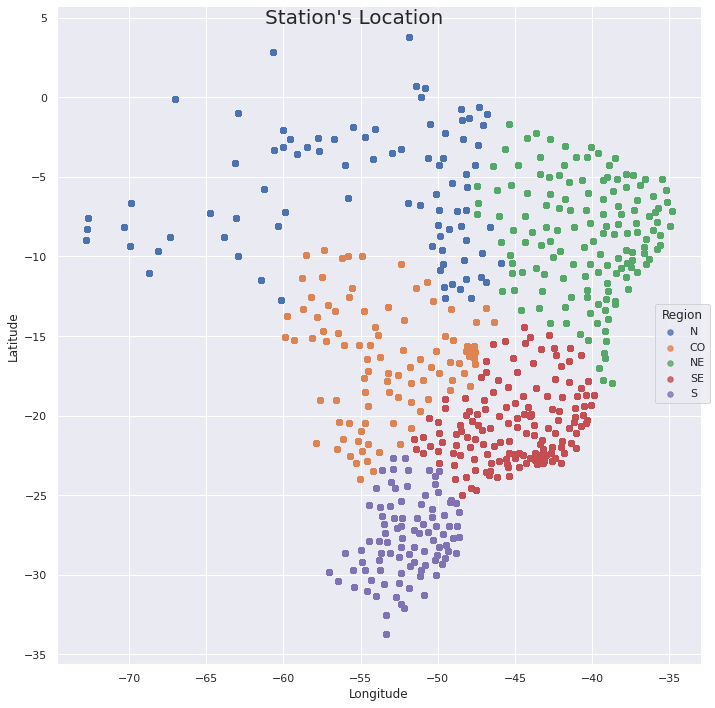

In [21]:
df = weather_df.copy()

df = df.drop(df.columns.difference(['longitude', 'latitude', 'region']), axis=1)
df = df.loc[df['latitude'] > -40]

stations = sns.lmplot(x="longitude", y="latitude", data=df, fit_reg=False, 
                      legend=False, scatter_kws={"s": 30}, hue='region', height=10)

stations.set(xlabel='Longitude', ylabel='Latitude')
stations.fig.suptitle("Station's Location", fontsize=20)
stations.fig.legend(labels=weather_df.region.unique(), loc='center right', title='Region')

plt.show()

## 3. Correlation Analysis.

Heatmap display plotting the correlation between the columns. Also, the repetition will be removed by plotting only the elements on the lower diagonal.

The graph will only display values for correlations less than -0.25 and greater than 0.25.

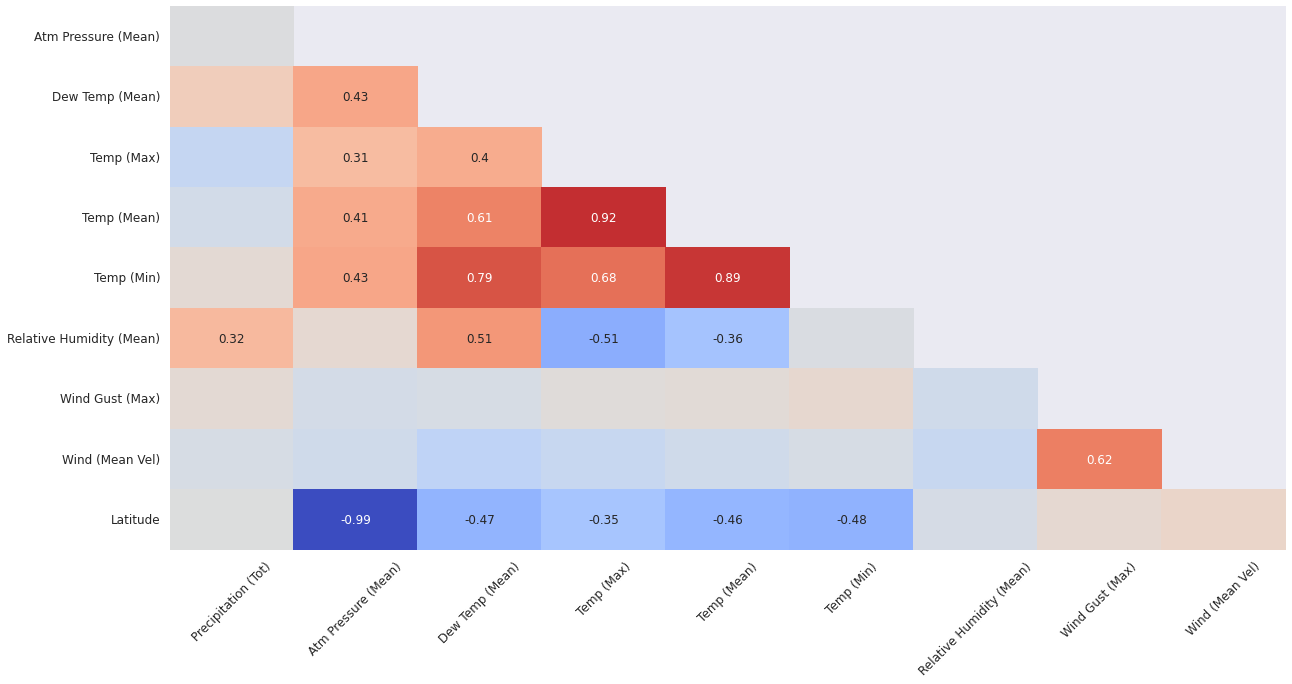

In [22]:
df = weather_df.loc[:, ['tot_precipitation', 'avg_atm_pressure', 'avg_dew_temp',
                        'max_temp', 'avg_temp', 'min_temp', 'avg_rel_humidity',
                        'max_blast_wind', 'avg_vel_wind',
                        'altitude']]

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df = df.corr()
df = df.iloc[1:,:-1]
   
mask = np.triu(np.ones_like(df), k=1)
    
plt.figure(figsize=(20,10))

col_names = ['tot_precipitation', 'avg_atm_pressure', 'avg_dew_temp', 'max_temp',
       'avg_temp', 'min_temp', 'avg_rel_humidity', 'min_rel_humidity',
       'max_blast_wind', 'avg_vel_wind', 'latitude', 'longitude']

x_axis_labels = ['Precipitation (Tot)', 'Atm Pressure (Mean)', 'Dew Temp (Mean)', 
                 'Temp (Max)', 'Temp (Mean)', 'Temp (Min)', 'Relative Humidity (Mean)', 
                 'Wind Gust (Max)', 'Wind (Mean Vel)']

y_axis_labels = ['Atm Pressure (Mean)', 'Dew Temp (Mean)', 
                 'Temp (Max)', 'Temp (Mean)', 'Temp (Min)', 'Relative Humidity (Mean)', 
                 'Wind Gust (Max)', 'Wind (Mean Vel)', 'Latitude']

ax = sns.heatmap(df, vmin=-1, vmax=1, cbar=False,
                 cmap='coolwarm', mask=mask, annot=True, 
                 xticklabels=x_axis_labels, yticklabels=y_axis_labels)

for text in ax.texts:
  value = float(text.get_text())
  if (-0.25 < value < 0.25):
    text.set_text('')
  else:
    text.set_text(round(value, 2))
  text.set_fontsize('12')

plt.xticks(rotation=45, size='12')
plt.yticks(size='12')
plt.show()

## 4. Maximum Temperature Variation in Brazil (per month)

We can see that the maximum temperature in Brazil reaches its highest value between the months of October and February. However, if we consider each region of Brazil, we can see that the highest temperature is reached in different months of the year.

##### Maximum Temperature Variation in Brazil.

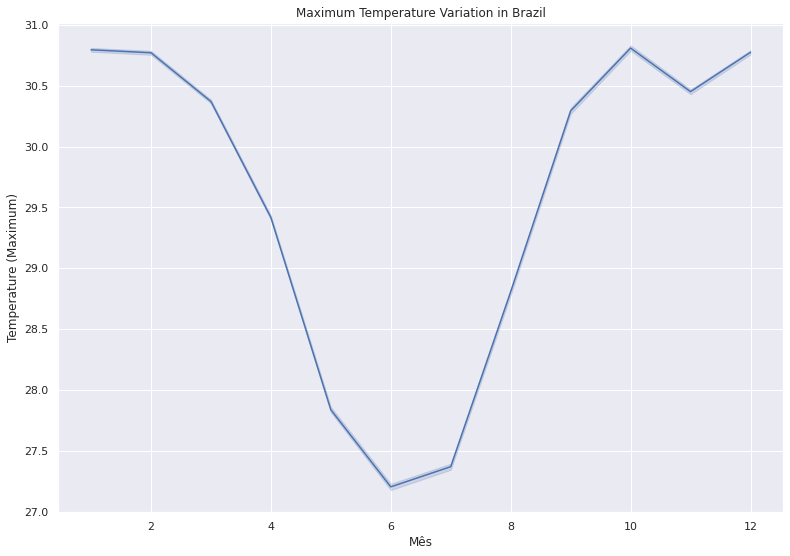

In [23]:
df = weather_df.loc[:,['max_temp', 'date', 'region']]
df.dropna(inplace=True)
df['month'] = pd.DatetimeIndex(df['date']).month

region = {'region': ['N', 'NE', 'CO', 'SE','S'], 
          'region_name': ['North','North East','Midwest','Southeast','South']}
region_df = pd.DataFrame(region)
df = pd.merge(left=df, right=region_df, left_on='region', right_on='region')

df = df.sort_values(by=['month'])
sns.set(rc={'figure.figsize':(13,9)})
ax = sns.lineplot(y="max_temp", x="month", data=df)
ax.set(xlabel='Mês', ylabel='Temperature (Maximum)', title='Maximum Temperature Variation in Brazil')
plt.show()

##### Maximum temperature variation by regions of Brazil.

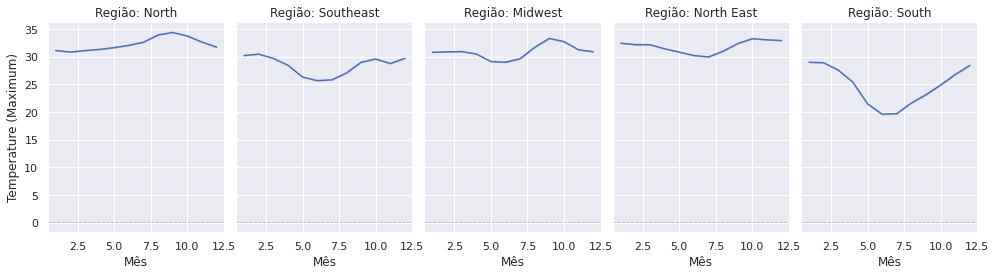

In [24]:
g = sns.relplot(data=df,
                x="month", y="max_temp",
                col="region_name", height=4, aspect=.7, kind="line"
)
(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("Mês", "Temperature (Maximum)")
  .set_titles("Região: {col_name}")
  .tight_layout(w_pad=0))

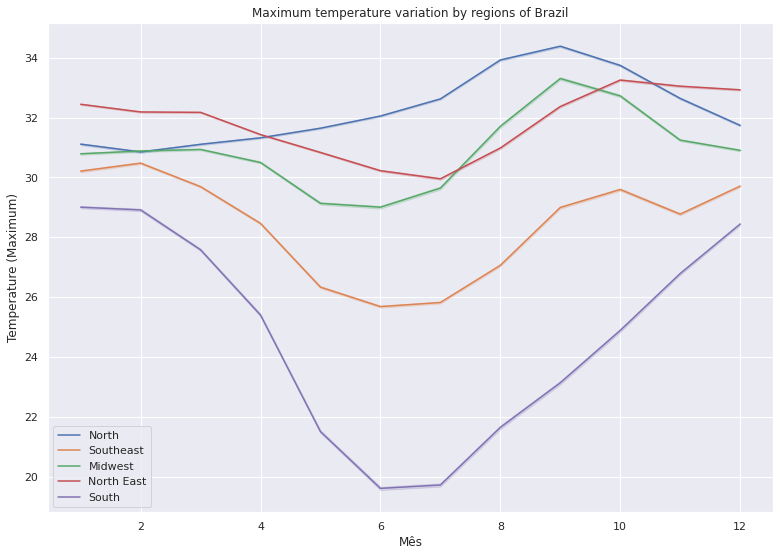

In [25]:
sns.set(rc={'figure.figsize':(13,9)})
ax = sns.lineplot(y="max_temp", x="month", data=df, hue='region_name')
ax.set(xlabel='Mês', ylabel='Temperature (Maximum)', title='Maximum temperature variation by regions of Brazil')
ax.legend().set_title('')
plt.show()

## 5. Variables by region (Average)

Checking the average of some variables, we can see that there are large variations by region. An example is the average exclusion in the Northeast region is considerably lower than in other regions.

In [26]:
df = weather_df.loc[:, ['tot_precipitation', 'avg_atm_pressure', 'avg_dew_temp',
                        'avg_temp', 'avg_rel_humidity', 'altitude', 'region']]
df.dropna(inplace=True)

columns = {'tot_precipitation': 'Precipitation (Total)', 
           'avg_atm_pressure': 'Atmospheric Pressure (Average)', 
           'avg_dew_temp': 'Dew Temperature (Average)', 
           'avg_temp': 'Temperature (Average)', 
           'avg_rel_humidity': 'Relative Humidity (Average)', 
           'altitude': 'Altitude'}

df.rename(columns=columns, inplace=True)

region = {'region': ['N', 'NE', 'CO', 'SE','S'], 
          'region_name': ['North','North East','Midwest','Southeast','South']}

region_df = pd.DataFrame(region)
df = pd.merge(left=df, right=region_df, left_on='region', right_on='region')

df = df.groupby(['region_name']).mean()
df.reset_index(level=0, inplace=True)

regions=df.region_name.unique()

fig = go.Figure(
    data=[
        go.Bar(name='Precipitation',
               x=regions, y=df['Precipitation (Total)'],
               yaxis='y',  offsetgroup=1),
        go.Bar(name='Atmospheric Pressure', 
               x=regions, y=df['Atmospheric Pressure (Average)'], 
               yaxis='y2', offsetgroup=2),
        go.Bar(name='Dew Temperature',        
               x=regions, y=df['Dew Temperature (Average)'],        
               yaxis='y3', offsetgroup=3),
        go.Bar(name='Temperature',
               x=regions, y=df['Temperature (Average)'],                
               yaxis='y4', offsetgroup=4),
        go.Bar(name='Relative Humidity',         
               x=regions, y=df['Relative Humidity (Average)'],         
               yaxis='y5', offsetgroup=5),
    ],
    layout={
        'yaxis':  {'title': '', 'visible': False, 'showticklabels': False,},
        'yaxis2': {'title': '', 'overlaying': 'y', 'side': 'right', 'visible': False, 'showticklabels': False},
        'yaxis3': {'title': '', 'overlaying': 'y', 'side': 'right', 'visible': False, 'showticklabels': False},
        'yaxis4': {'title': '', 'overlaying': 'y', 'side': 'right', 'visible': False, 'showticklabels': False},
        'yaxis5': {'title': '', 'overlaying': 'y', 'side': 'right', 'visible': False, 'showticklabels': False},
    }
)

fig.update_layout(barmode='group')
fig.show()

## 6. Variation of Relative Air Humidity (Average)

In [27]:
df = weather_df.loc[:,['date', 'avg_rel_humidity', 'region', 'uf']]
df.dropna(inplace=True)

region = {'region': ['N', 'NE', 'CO', 'SE','S'], 
          'region_name': ['North','North East','Midwest','Southeast','South']}

region_df = pd.DataFrame(region)
df = pd.merge(left=df, right=region_df, left_on='region', right_on='region')

df = df.sample(10000)

### by Region

We can observe that the North region has a smaller interquartile range than the other regions. We also see that the minimum value is quite high when compared to other regions. Which generates a large range of outliers.

In [28]:
fig = go.Figure()

fig.add_trace(go.Box(x=df['region_name'], y=df['avg_rel_humidity'],
                     notched=False))

fig.update_layout(boxmode='group')
fig.show()

### by North Region

When we analyze the states of the northern region, we only observe the state of Tocantins with data diverging from the region's data. Presenting greater range and interquartile range.

In [29]:
fig = go.Figure()

nort_df = df.loc[df['region'] == 'N',:]

fig = go.Figure()

fig.add_trace(go.Box(x=nort_df['uf'], y=nort_df['avg_rel_humidity'],
                     notched=False))

fig.update_layout(boxmode='group')
fig.show()

### by States

In general, states present information similar to the region's data, with some exceptions that can be easily identified.

In [30]:
fig = go.Figure()

for i, region in enumerate(df['region_name'].unique()):
    df_plot = df[df['region_name']==region]
    
    fig.add_trace(go.Box(x=df_plot['uf'], y=df_plot['avg_rel_humidity'],
                         notched=False,
                         name='Region: ' + region))

fig.update_layout(boxmode='group')
fig.show()

## 7. Accumulated rainfall in Brazil

In [31]:
df = weather_df.loc[:,['date', 'tot_precipitation', 'region', 'uf']]
df.dropna(inplace=True)
df = df.sample(10000)

df['year_month'] = pd.to_datetime(df['date']).dt.to_period('M')

region = {'region': ['N', 'NE', 'CO', 'SE','S'], 
          'region_name': ['North','North East','Midwest','Southeast','South']}

region_df = pd.DataFrame(region)
df = pd.merge(left=df, right=region_df, left_on='region', right_on='region')

df = df.sort_values(by=['year_month'])

### by Region

In [32]:
region_df = df.copy()

region_df = region_df.pivot_table(values='tot_precipitation', index = ['year_month'], columns = 'region_name')
region_df = region_df.fillna(0)

region_df.sort_values(list(region_df.columns),inplace=True)
region_df = region_df.sort_index()

region_df.iloc[:, 0:-1] = region_df.iloc[:, 0:-1].cumsum()

top_rainning = set()
for index, row in region_df.iterrows():
    top_rainning |= set(row[row > 0].sort_values(ascending=False).index)

region_df = region_df[top_rainning]

In [33]:
%%capture
chart = bcr.bar_chart_race(df=region_df, 
                           n_bars=5,
                           sort='desc',
                           title='Accumulated rainfall by Regions of Brazil',
                           title_size=10,
                           bar_kwargs={'alpha': .7})

In [34]:
chart

### by States of North East region

In [35]:
uf_df = df.loc[df['region'].isin(['NE']),:]

uf_df = uf_df.pivot_table(values='tot_precipitation', index = ['year_month'], columns = 'uf')
uf_df = uf_df.fillna(0)

uf_df.sort_values(list(uf_df.columns),inplace=True)
uf_df = uf_df.sort_index()

uf_df.iloc[:, 0:-1] = uf_df.iloc[:, 0:-1].cumsum()

top_rainning = set()
for index, row in uf_df.iterrows():
    top_rainning |= set(row[row > 0].sort_values(ascending=False).index)

uf_df = uf_df[top_rainning]

In [36]:
%%capture
chart = bcr.bar_chart_race(df=uf_df, 
                           n_bars=9,
                           sort='desc',
                           title='Accumulated rainfall by states of North East region of Brazil',
                           title_size=10,
                           bar_kwargs={'alpha': .7})

In [37]:
chart

## 8. Relationship between precipitation and maximum temperature

Comparison between three Brazilian cities showing the relationship between temperature and the amount of rainfall.

#### Porto Alegre - RS

City with temperature defined according to the seasons. We can also see that rains happen throughout the year and that historically the number of days without rain is greater than the number of days with rain.

In [38]:
df = weather_df.loc[(weather_df['cityname'].isin(['PORTO ALEGRE'])),['cityname', 'date', 'tot_precipitation', 'max_temp']]
df = df.dropna()

df = df.sample(5000)

df['weather'] = ''

for i in range(len(df)):
  df.iloc[i, 4] = ('no rain' if (df.iloc[i, 2] > 0) else 'rain')

scale = alt.Scale(domain=['no rain', 'rain'],
                  range=['#d4571e', '#211ed4'])
color = alt.Color('weather:N', scale=scale, title='Climate')

brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

points = alt.Chart().mark_point().encode(
    alt.X('monthdate(date):T', title='Date'),
    alt.Y('max_temp:Q',
        title='Daily Maximum Temperature (Celsius)',
        scale=alt.Scale(domain=[8, 38])
    ),
    color=alt.condition(brush, color, alt.value('lightgray')),
    size=alt.Size('tot_precipitation:Q', scale=alt.Scale(range=[5, 200]), title='Precipitation')
).properties(
    width=800,
    height=500
).add_selection(
    brush
).transform_filter(
    click
)

bars = alt.Chart().mark_bar().encode(
    x='count()',
    y=alt.Y('weather:N',
            title='Climate'),
    color=alt.condition(click, color, alt.value('lightgray')),
).transform_filter(
    brush
).properties(
    width=800
).add_selection(
    click
)

In [39]:
alt.vconcat(
    points,
    bars,
    data=df,
    title="Porto Alegre: Precipitation x Maximum Temperature",
)

alt.VConcatChart(...)

#### Teresina - PI

Teresina presents higher temperatures between the months of September and December. It has a rainy period between January and May, with more than twice the number of days without rain.

In [40]:
df = weather_df.loc[(weather_df['cityname'].isin(['TERESINA'])),['cityname', 'date', 'tot_precipitation', 'max_temp']]
df = df.dropna()

df['weather'] = ''

for i in range(len(df)):
  df.iloc[i, 4] = ('no rain' if (df.iloc[i, 2] > 0) else 'rain')

scale = alt.Scale(domain=['no rain', 'rain'],
                  range=['#d4571e', '#211ed4'])
color = alt.Color('weather:N', scale=scale, title='Climate')

brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

points = alt.Chart().mark_point().encode(
    alt.X('monthdate(date):T', title='Date'),
    alt.Y('max_temp:Q',
        title='Daily Maximum Temperature (Celsius)',
        scale=alt.Scale(domain=[25, 42])
    ),
    color=alt.condition(brush, color, alt.value('lightgray')),
    size=alt.Size('tot_precipitation:Q', scale=alt.Scale(range=[5, 200]), title='Precipitation')
).properties(
    width=800,
    height=500
).add_selection(
    brush
).transform_filter(
    click
)

bars = alt.Chart().mark_bar().encode(
    x='count()',
    y=alt.Y('weather:N',
            title='Climate'),
    color=alt.condition(click, color, alt.value('lightgray')),
).transform_filter(
    brush
).properties(
    width=800
).add_selection(
    click
)

In [41]:
alt.vconcat(
    points,
    bars,
    data=df,
    title="Teresina: Precipitation x Maximum Temperature",
)

alt.VConcatChart(...)

#### Belem - PA

Historically, the number of days without rain in Belem is 1/3 of the rainy days. Belem has lower temperatures between the months of December and May, which are the months with the greatest amounts of rain. We can also see that in December and January there are some days with high temperatures, surpassing the 40º Celsius mark.

In [42]:
df = weather_df.loc[(weather_df['cityname'].isin(['BELEM'])),['cityname', 'date', 'tot_precipitation', 'max_temp']]
df = df.dropna()
df = df.sample(5000)

df['weather'] = ''

for i in range(len(df)):
  df.iloc[i, 4] = ('no rain' if (df.iloc[i, 2] > 0) else 'rain')

scale = alt.Scale(domain=['no rain', 'rain'],
                  range=['#d4571e', '#211ed4'])
color = alt.Color('weather:N', scale=scale, title='Climate')

brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

points = alt.Chart().mark_point().encode(
    alt.X('monthdate(date):T', title='Date'),
    alt.Y('max_temp:Q',
        title='Daily Maximum Temperature (Celsius)',
        scale=alt.Scale(domain=[24, 40])
    ),
    color=alt.condition(brush, color, alt.value('lightgray')),
    size=alt.Size('tot_precipitation:Q', scale=alt.Scale(range=[5, 200]), title='Precipitation')
).properties(
    width=800,
    height=500
).add_selection(
    brush
).transform_filter(
    click
)

bars = alt.Chart().mark_bar().encode(
    x='count()',
    y=alt.Y('weather:N',
            title='Climate'),
    color=alt.condition(click, color, alt.value('lightgray')),
).transform_filter(
    brush
).properties(
    width=800
).add_selection(
    click
)

In [43]:
alt.vconcat(
    points,
    bars,
    data=df,
    title="Belem: Precipitation x Maximum Temperature",
)

alt.VConcatChart(...)

## 9. Total precipitation in the capitals of Brazil

Total Precipitation in Brazilian capitals represented by the size on the map.

In [44]:
capitals = [
  'Porto Velho', 'Manaus', 'Rio Branco', 'Campo Grande', 'Macapa', 'Brasilia',
  'Boa Vista', 'Cuiaba', 'Palmas', 'Sao Paulo', 'Teresina', 'Rio de Janeiro',
  'Belem', 'Goiania', 'Salvador', 'Florianopolis', 'São Luis', 'Maceio',
  'Porto Alegre', 'Curitiba', 'Belo Horizonte', 'Fortaleza', 'Recife', 
  'Joao Pessoa', 'Aracaju', 'Natal', 'Vitoria']
capitals = [name.upper() for name in capitals]

df = weather_df.loc[weather_df['cityname'].isin(capitals),['date', 'tot_precipitation', 'cityname']]
df['year'] = pd.DatetimeIndex(df['date']).year
df = df.loc[df['year'] == 2020,:]
df = df.groupby(['cityname'])['tot_precipitation'].sum().reset_index()

location = weather_df.loc[:,['cityname', 'latitude',	'longitude']]
df = pd.merge(left=location, right=df, left_on='cityname', right_on='cityname')
df = df.drop_duplicates()

fig = Figure(width=800, height=600)

chart = folium.Map(width=800, height=600,
                   location=[-16, -49], zoom_start = 3, 
                   tiles = "cartodbpositron")

for i in range(0,len(df)):
    popup_text = """City: {}<br>
                    Rain Accumulated: {:.2f}<br>"""
    popup_text = popup_text.format(df.iloc[i]['cityname'],
                    df.iloc[i]['tot_precipitation'])
    folium.Circle(
      location=[df.iloc[i]['latitude'], df.iloc[i]['longitude']],
      radius = float(df.iloc[i]['tot_precipitation'])*70,
      popup = popup_text,
      color = 'red',
      fill=True,
      fill_color='blue'
   ).add_to(chart)

In [45]:
fig.add_child(chart)

## 10. Total Precipitation x Altitude

Representation of Total Precipitation in all Brazilian cities, related to altitude.

Cities are presented by state/region of Brazil.

In [46]:
df = weather_df.loc[:,['tot_precipitation', 'altitude', 'avg_atm_pressure', 'region', 'uf', 'cityname', 'station']]
df.dropna(inplace=True)

precipitation_df = df.groupby(['cityname', 'station', 'uf', 'region'])['tot_precipitation'].sum().reset_index()
altitude_df = df.groupby(['cityname', 'station', 'uf', 'region'])['altitude'].mean().reset_index()
atm_pressure_df = df.groupby(['cityname', 'station', 'uf', 'region'])['avg_atm_pressure'].mean().reset_index()

df = pd.merge(precipitation_df, altitude_df, how='inner', left_on=['cityname', 'station', 'uf', 'region'], right_on=['cityname', 'station', 'uf', 'region'])
df = pd.merge(df, atm_pressure_df, how='inner', left_on=['cityname', 'station', 'uf', 'region'], right_on=['cityname', 'station', 'uf', 'region'])

region = {'region': ['N', 'NE', 'CO', 'SE','S'], 
          'region_name': ['North','North East','Midwest','Southeast','South']}
region_df = pd.DataFrame(region)

df = pd.merge(left=df, right=region_df, left_on='region', right_on='region')

In [47]:
fig = px.treemap(df, path=[px.Constant('brazil'), 'region', 'uf', 'cityname'], values='tot_precipitation',
                  color='altitude')
fig.show()